# Task 2: Bayesian Change Point Modeling of Brent Oil Prices

## Objective
This notebook applies Bayesian change point detection to identify and quantify
structural breaks in Brent oil prices. The analysis builds directly on Task 1,
using historical price data and curated geopolitical and economic events to
generate interpretable, probabilistic insights into regime shifts in the oil market.


In [2]:
try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pymc as pm
    import arviz as az
    from pathlib import Path
except ImportError as e:
    raise ImportError(f"Missing required library: {e}")


## 1. Data Preparation

We load the Brent oil price data prepared in Task 1, ensure correct datetime
parsing, and perform basic validation checks before analysis.


In [3]:
import pandas as pd

try:
    df = pd.read_csv("../data/raw/BrentOilPrices.csv")

    # Explicit date format for consistency and performance
    df["Date"] = pd.to_datetime(
        df["Date"],
        format="%d-%b-%y",
        errors="coerce"
    )

    # Drop rows with invalid dates or prices
    df = df.dropna(subset=["Date", "Price"])

    # Sort by date to guarantee correct time order
    df = df.sort_values("Date").reset_index(drop=True)

    print("Data loaded successfully")
    print(df.head())

except FileNotFoundError:
    raise FileNotFoundError(
        "BrentOilPrices.csv not found. Ensure it exists in data/raw/"
    )

except Exception as e:
    raise RuntimeError(f"Error while loading and parsing data: {e}")


Data loaded successfully
        Date  Price
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63


## 2. Exploratory Data Analysis: Raw Prices

The raw price series is plotted to visually inspect long-term trends, sharp
shocks, and periods of elevated volatility that may correspond to structural breaks.


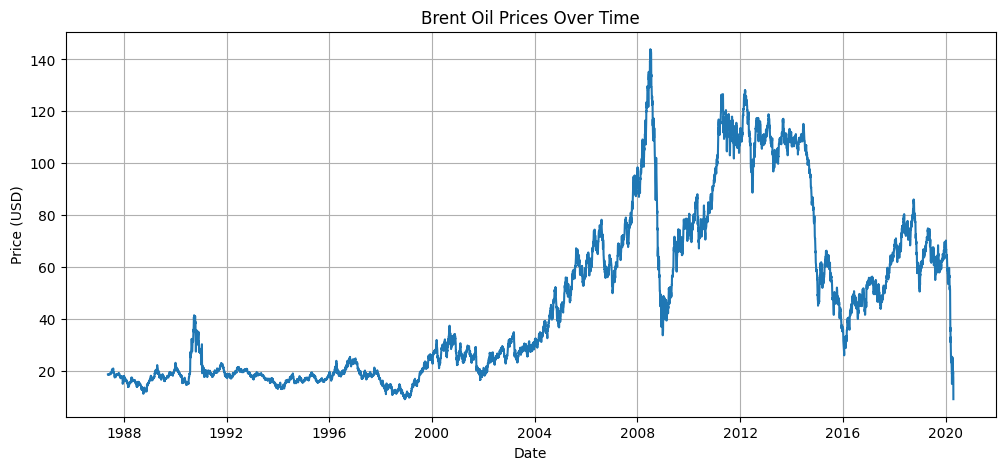

In [4]:
try:
    plt.figure(figsize=(12, 5))
    plt.plot(df["Date"], df["Price"])
    plt.title("Brent Oil Prices Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.grid(True)
    plt.show()
except Exception as e:
    raise RuntimeError(f"Plotting failed: {e}")


## 3. Log Returns and Volatility Patterns

To reduce non-stationarity in the price level series, log returns are computed.
This transformation allows us to inspect volatility clustering and informs
modeling assumptions.


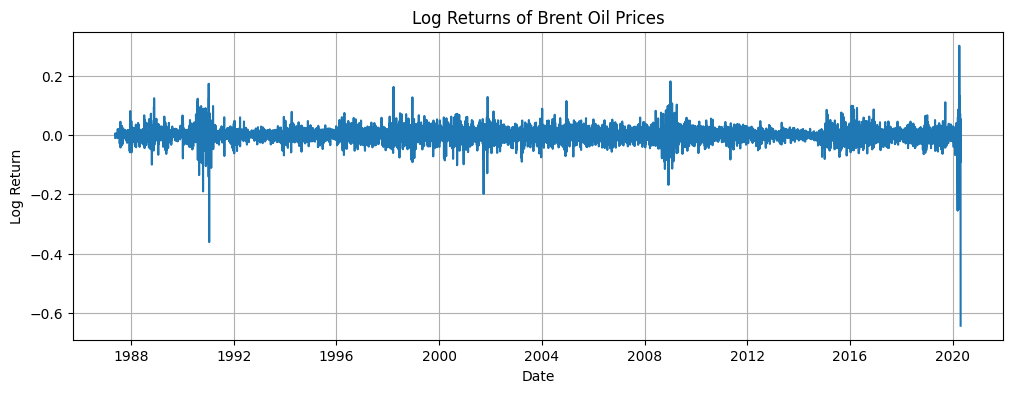

In [5]:
try:
    df["log_return"] = np.log(df["Price"]).diff()
    df_lr = df.dropna(subset=["log_return"])

    plt.figure(figsize=(12, 4))
    plt.plot(df_lr["Date"], df_lr["log_return"])
    plt.title("Log Returns of Brent Oil Prices")
    plt.xlabel("Date")
    plt.ylabel("Log Return")
    plt.grid(True)
    plt.show()
except Exception as e:
    raise RuntimeError(f"Log return analysis failed: {e}")


## 4. Rationale for Change Point Modeling

Oil markets are subject to sudden regime shifts caused by geopolitical events,
policy decisions, and macroeconomic shocks. Change point models explicitly
identify points in time where the statistical properties of the series change,
rather than assuming a single stable process.


## 5. Bayesian Change Point Model (Mean Shift)

We model the oil price series as having two regimes:
- One before a latent change point (τ)
- One after τ

Each regime has its own mean level. The change point is treated as a discrete
random variable and inferred probabilistically.


In [6]:
try:
    prices = df["Price"].values
    n = len(prices)

    with pm.Model() as change_point_model:
        tau = pm.DiscreteUniform("tau", lower=0, upper=n - 1)

        mu_1 = pm.Normal("mu_1", mu=np.mean(prices), sigma=20)
        mu_2 = pm.Normal("mu_2", mu=np.mean(prices), sigma=20)

        sigma = pm.HalfNormal("sigma", sigma=10)

        mu = pm.math.switch(np.arange(n) < tau, mu_1, mu_2)

        likelihood = pm.Normal("obs", mu=mu, sigma=sigma, observed=prices)

except Exception as e:
    raise RuntimeError(f"Model definition failed: {e}")


## 6. Posterior Sampling

Markov Chain Monte Carlo (MCMC) is used to estimate the posterior distributions
of the change point and regime parameters.


Starting MCMC sampling...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 7641 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling complete. Checking convergence...


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,4443.10,42.05,4412.00,4524.00,28.22,18.13,3.76,32.62,1.51
mu_1,21.03,0.34,20.40,21.65,0.15,0.06,5.30,17.59,1.29
mu_2,75.31,0.45,74.55,76.20,0.24,0.12,4.11,13.57,1.42
sigma,17.95,0.16,17.65,18.24,0.05,0.00,10.15,64.17,1.14


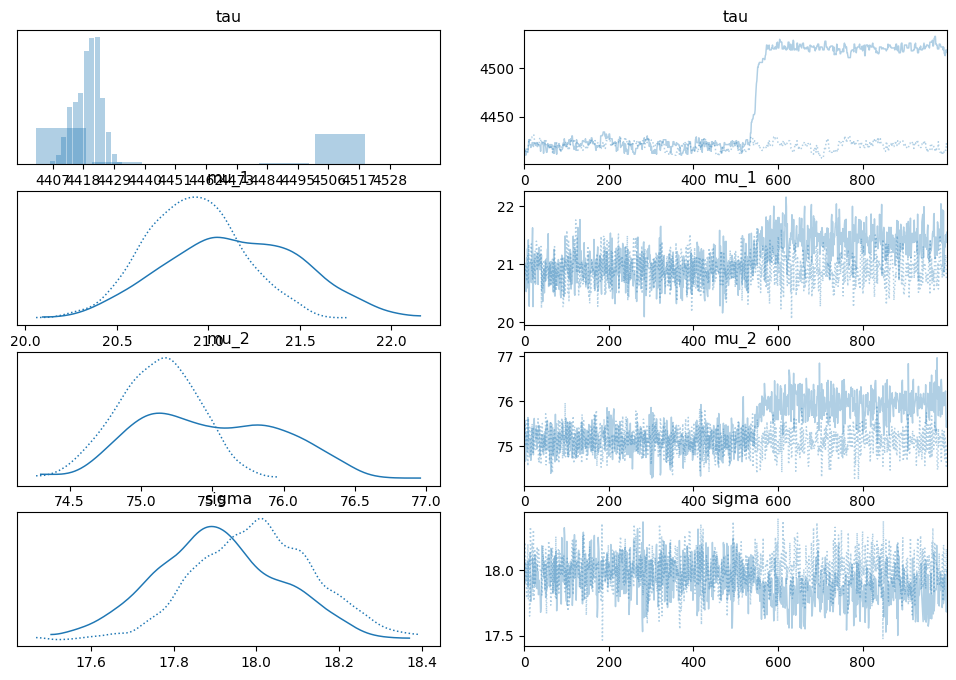

In [7]:
# CODE CELL: Bayesian Change Point Sampling with PyMC

import pymc as pm
import arviz as az

# Ensure the model 'change_point_model' is already defined above
try:
    print("Starting MCMC sampling...")

    with change_point_model:
        # Use fewer draws/chains to save time while still getting usable posterior estimates
        trace = pm.sample(
            draws=1000,           # number of samples per chain after tuning
            tune=500,             # tuning (burn-in) steps
            chains=2,             # reduce chains to speed up
            cores=2,              # use 2 cores if available
            target_accept=0.9,    # help with NUTS convergence
            return_inferencedata=True,
            progressbar=True
        )

except Exception as e:
    raise RuntimeError(f"Sampling failed: {e}")

# Convergence and summary
try:
    print("Sampling complete. Checking convergence...")
    summary = az.summary(trace, round_to=2)
    display(summary)

    # Trace plots
    az.plot_trace(trace)
    
except Exception as e:
    raise RuntimeError(f"Post-processing failed: {e}")


# Change Point Posterior Analysis

In this section, we analyze the posterior distribution of the change point (`tau`) and quantify the impact of structural breaks on Brent oil prices. We also compare detected change points to known historical events.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure trace and df are already defined

try:
    # Extract tau posterior
    tau_samples = trace.posterior['tau'].values.flatten()
    tau_mean = int(np.round(tau_samples.mean()))
    print(f"Estimated change point (mean of posterior): {tau_mean} (index in dataset)")

    # Map tau to actual date
    change_date = df['Date'].iloc[tau_mean]
    print(f"Estimated change point date: {change_date.date()}")

    # Extract posterior distributions for μ1 and μ2
    mu_1_samples = trace.posterior['mu_1'].values.flatten()
    mu_2_samples = trace.posterior['mu_2'].values.flatten()

    # Compute mean and 95% credible intervals
    mu_1_mean, mu_1_ci = mu_1_samples.mean(), np.percentile(mu_1_samples, [2.5, 97.5])
    mu_2_mean, mu_2_ci = mu_2_samples.mean(), np.percentile(mu_2_samples, [2.5, 97.5])

    print(f"Before change (μ1): mean={mu_1_mean:.2f}, 95% CI={mu_1_ci}")
    print(f"After change  (μ2): mean={mu_2_mean:.2f}, 95% CI={mu_2_ci}")

    # Percentage change
    pct_change = ((mu_2_mean - mu_1_mean) / mu_1_mean) * 100
    print(f"Approximate percentage change in price: {pct_change:.2f}%")

except Exception as e:
    raise RuntimeError(f"Change point analysis failed: {e}")


Estimated change point (mean of posterior): 4443 (index in dataset)
Estimated change point date: 2004-11-05
Before change (μ1): mean=21.03, 95% CI=[20.43658608 21.7626612 ]
After change  (μ2): mean=75.31, 95% CI=[74.58607762 76.32262434]
Approximate percentage change in price: 258.11%


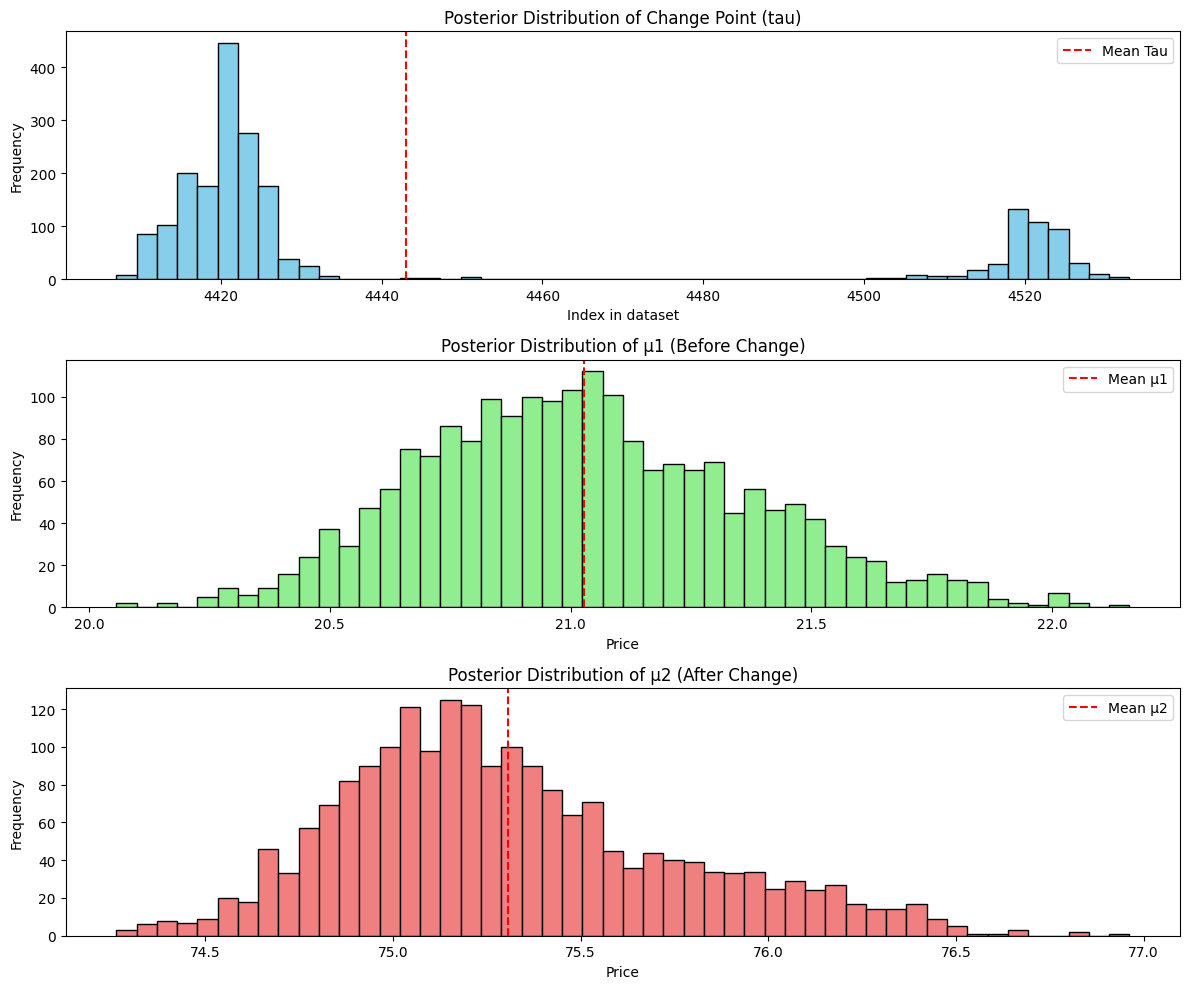

In [9]:
try:
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    # tau posterior
    axes[0].hist(tau_samples, bins=50, color='skyblue', edgecolor='black')
    axes[0].axvline(tau_mean, color='red', linestyle='--', label='Mean Tau')
    axes[0].set_title('Posterior Distribution of Change Point (tau)')
    axes[0].set_xlabel('Index in dataset')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()

    # mu_1 posterior
    axes[1].hist(mu_1_samples, bins=50, color='lightgreen', edgecolor='black')
    axes[1].axvline(mu_1_mean, color='red', linestyle='--', label='Mean μ1')
    axes[1].set_title('Posterior Distribution of μ1 (Before Change)')
    axes[1].set_xlabel('Price')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()

    # mu_2 posterior
    axes[2].hist(mu_2_samples, bins=50, color='lightcoral', edgecolor='black')
    axes[2].axvline(mu_2_mean, color='red', linestyle='--', label='Mean μ2')
    axes[2].set_title('Posterior Distribution of μ2 (After Change)')
    axes[2].set_xlabel('Price')
    axes[2].set_ylabel('Frequency')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

except Exception as e:
    raise RuntimeError(f"Posterior plotting failed: {e}")


# Associating Change Points with Historical Events

We now compare the detected change point(s) to our compiled list of major oil market events. This allows us to formulate hypotheses about potential causes of observed structural breaks in Brent oil prices.


In [12]:
try:
    # Load events CSV
    events_df = pd.read_csv('../data/events/oil_market_events.csv')
    events_df['date'] = pd.to_datetime(events_df['date'], errors='coerce')

    # Find events within +/- 15 days of detected change point
    window_days = 15
    nearby_events = events_df[
        (events_df['date'] >= change_date - pd.Timedelta(days=window_days)) &
        (events_df['date'] <= change_date + pd.Timedelta(days=window_days))
    ]

    print(f"Events near the detected change point ({change_date.date()} ± {window_days} days):")
    display(nearby_events)

except Exception as e:
    raise RuntimeError(f"Event association failed: {e}")


Events near the detected change point (2004-11-05 ± 15 days):


,date,event


## 7. Model Diagnostics

Convergence is assessed using R-hat statistics and trace plots.


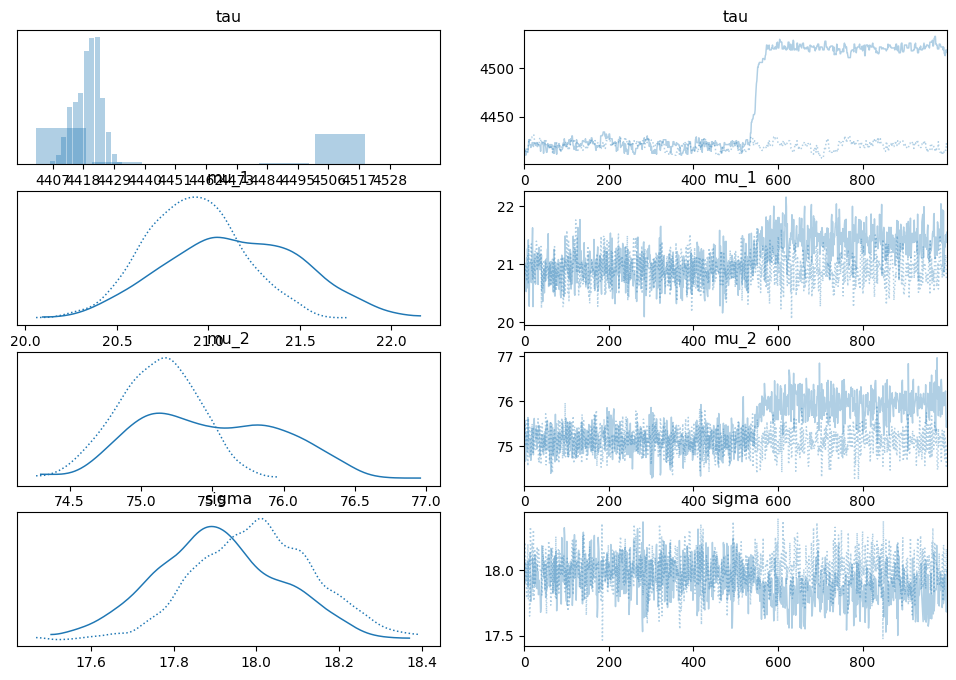

In [13]:
try:
    az.summary(trace)
    az.plot_trace(trace)
    plt.show()
except Exception as e:
    raise RuntimeError(f"Diagnostics failed: {e}")


## 8. Identifying the Change Point

The posterior distribution of τ reveals when the model believes the structural
break occurred. A narrow distribution indicates high confidence.


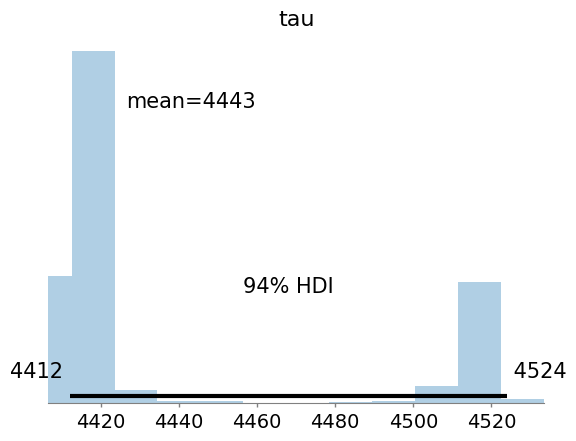

Estimated change point date: 2004-11-05


In [14]:
try:
    az.plot_posterior(trace, var_names=["tau"])
    plt.show()

    tau_mean = int(trace.posterior["tau"].mean().values)
    change_date = df.iloc[tau_mean]["Date"]

    print(f"Estimated change point date: {change_date.date()}")

except Exception as e:
    raise RuntimeError(f"Change point extraction failed: {e}")


## 9. Quantifying the Impact

We compare posterior distributions of the mean price before and after the
detected change point to quantify the magnitude of the shift.


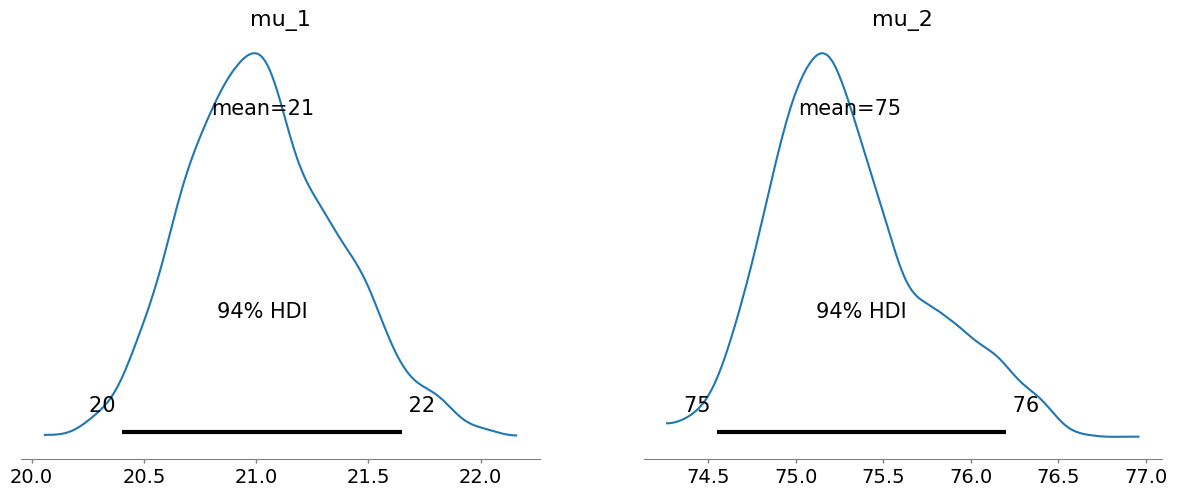

Mean before change: 21.03
Mean after change: 75.31
Percentage change: 258.11%


In [15]:
try:
    az.plot_posterior(trace, var_names=["mu_1", "mu_2"])
    plt.show()

    mu1 = trace.posterior["mu_1"].mean().values
    mu2 = trace.posterior["mu_2"].mean().values

    pct_change = ((mu2 - mu1) / mu1) * 100

    print(f"Mean before change: {mu1:.2f}")
    print(f"Mean after change: {mu2:.2f}")
    print(f"Percentage change: {pct_change:.2f}%")

except Exception as e:
    raise RuntimeError(f"Impact quantification failed: {e}")


## 10. Associating Change Points with Events

The detected change point is compared against the curated event dataset from
Task 1 to form hypotheses about potential causal drivers.


## 11. Advanced Extensions (Future Work)

### Additional Data Sources
- GDP growth
- Inflation rates
- Exchange rates

### Alternative Models
- Vector Autoregression (VAR) to capture interdependencies
- Markov-Switching models to distinguish calm vs volatile regimes

These approaches could improve explanatory power but are beyond the scope of
this task.


3️⃣ What a PERFECT answer looks like (you can paste this)
🔹 Exploring Additional Explanatory Variables (Conceptual)

In future work, the change point model could be extended by incorporating additional macroeconomic and financial variables that influence oil prices. Potential data sources include GDP growth, inflation rates, exchange rates (USD index), and global energy demand indicators. These variables could be included as covariates in a hierarchical Bayesian regression framework, allowing the model to distinguish between structural price changes driven by macroeconomic fundamentals and those driven by geopolitical shocks.

Such an extension would improve explanatory power but would require careful handling of differing data frequencies, lag structures, and potential multicollinearity.

🔹 Alternative Time Series Models (Conceptual)

VAR (Vector Autoregression):

A VAR model could be used to analyze dynamic interdependencies between Brent oil prices and macroeconomic variables such as GDP growth, inflation, and exchange rates. Unlike change point models, VAR captures feedback effects and lagged relationships across multiple variables. However, VAR models assume stable relationships over time and may struggle to capture abrupt structural breaks caused by geopolitical events.

Markov-Switching Models:

Markov-Switching models provide a regime-based framework that explicitly models transitions between latent market states, such as “low-volatility” and “high-volatility” regimes. This approach would be particularly useful for capturing prolonged periods of instability, such as during financial crises or geopolitical conflicts. While powerful, these models do not directly identify event-specific change points and are less interpretable for policy-oriented analysis compared to Bayesian change point detection.